# JAK2 Max Analysis

In [1]:
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


## Imports

In [2]:
import os
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from irelease.utils import generate_smiles, canonical_smiles
import nb_utils as nbu
from math import ceil
from sklearn.manifold import TSNE
import pandas as pd
import rdkit.Chem as Chem
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Draw

RDKit WARNING: [01:28:24] Enabling RDKit 2019.09.3 jupyter extensions


mol_metrics: reading NP model ...
loaded in 0.08870625495910645
mol_metrics: reading SA model ...
loaded in 0.3692593574523926


In [3]:
DrawingOptions.atomLabelFontSize = 50
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3

## Load SMILES files

In [4]:
ppo_grl_train = 'jak2_max/JAK2_max_IReLeaSE-PPO_with_irl.json'
ppo_grl_eval = 'jak2_max/JAK2_max_smiles_biased_ppo_grl_eval.json'
ppo_baseline_reward_train = 'jak2_max/JAK2_max_IReLeaSE-PPO__baseline_reward.json'
ppo_baseline_reward_eval = 'jak2_max/JAK2_max_smiles_biased_ppo_baseline_reward_eval.json'
reinforce_train = 'jak2_max/JAK2_max_IReLeaSE-REINFORCE_no_irl.json'
reinforce_eval = 'jak2_max/JAK2_max_smiles_biased_reinforce_eval.json'
reinforce_grl_train = 'jak2_max/JAK2_max_IReLeaSE-REINFORCE_with_irl.json'
reinforce_grl_eval = 'jak2_max/JAK2_max_smiles_biased_reinforce_grl_eval.json'

In [5]:
ppo_grl_smiles_valid,  ppo_grl_smiles_invalid = nbu.smiles_from_json_data(ppo_grl_eval)
ppo_grl_conv = nbu.get_convergence_data(ppo_grl_train)
ppo_baseline_reward_smiles_valid, ppo_baseline_reward_smiles_invalid = nbu.smiles_from_json_data(ppo_baseline_reward_eval)
ppo_baseline_reward_conv = nbu.get_convergence_data(ppo_baseline_reward_train)
reinforce_smiles_valid, reinforce_smiles_invalid = nbu.smiles_from_json_data(reinforce_eval)
reinforce_conv = nbu.get_convergence_data(reinforce_train)
reinforce_grl_smiles_valid, reinforce_grl_smiles_invalid = nbu.smiles_from_json_data(reinforce_grl_eval)
reinforce_grl_conv = nbu.get_convergence_data(reinforce_grl_train)
len(ppo_grl_smiles_valid), len(ppo_baseline_reward_smiles_valid), len(reinforce_smiles_valid), len(reinforce_grl_smiles_valid)

(5922, 6945, 6782, 7046)

In [6]:
# CSV files containing predictions/evaluations
preds_ppo_grl_eval = pd.read_csv('jak2_max/JAK2_max_smiles_biased_ppo_grl_eval.csv')
preds_ppo_baseline_reward_eval = pd.read_csv('jak2_max/JAK2_max_smiles_biased_ppo_baseline_reward_eval.csv')
preds_reinforce_eval = pd.read_csv('jak2_max/JAK2_max_smiles_biased_reinforce_eval.csv')
preds_reinforce_grl_eval = pd.read_csv('jak2_max/JAK2_max_smiles_biased_reinforce_grl_eval.csv')
preds_demo = pd.read_csv('jak2_max/jak2_max_biased.csv')
preds_unbiased = pd.read_csv('jak2_max/jak2_unbiased.csv')
preds_ppo_grl_eval.shape, preds_ppo_baseline_reward_eval.shape, preds_reinforce_eval.shape, preds_reinforce_grl_eval.shape, preds_demo.shape, preds_unbiased.shape

((5922, 2), (6945, 2), (6782, 2), (7046, 2), (10000, 2), (10000, 2))

In [7]:
preds_ppo_grl_eval.shape[0] / 10000. * 100., preds_ppo_baseline_reward_eval.shape[0] / 10000. * 100., preds_reinforce_eval.shape[0] / 10000. * 100., preds_reinforce_grl_eval.shape[0] / 10000. * 100., preds_demo.shape[0] / 10000. * 100., preds_unbiased.shape[0] / 10000. * 100.

(59.21999999999999, 69.45, 67.82000000000001, 70.46, 100.0, 100.0)

## Evaluate SMILES

In [8]:
generators = nbu.data_provider('../../data/jak2_max_smiles_biased.smi', '../../data/unbiased_smiles.smi')

In [9]:
demo_smiles = generators['demo_data'].random_training_set_smiles(1000)
unbiased_smiles = generators['unbiased_data'].random_training_set_smiles(1000)

In [10]:
demo_smiles[0], unbiased_smiles[0]

('Cc1ccccc1S(=O)(=O)N1CCN(S(=O)(=O)N2CCN(S(=O)(=O)N3CCNCC3)CC2)CC1',
 'O=C(CC1Cc2ccccc2NC1=O)NNCc1cccc(F)c1')

In [11]:
preds_ppo_grl_smiles = preds_ppo_grl_eval['prediction'].tolist()
preds_ppo_baseline_reward_smiles = preds_ppo_baseline_reward_eval['prediction'].tolist()
preds_reinforce_smiles = preds_reinforce_eval['prediction'].tolist()
preds_reinforce_grl_smiles = preds_reinforce_grl_eval['prediction'].tolist()
preds_demo_smiles = preds_demo['prediction'].tolist()
preds_unbiased_smiles = preds_unbiased['prediction'].tolist()

## KDE plots

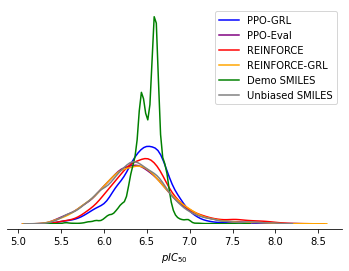

In [12]:
sns.kdeplot(preds_ppo_grl_smiles, label='PPO-GRL', shade=False, color='blue')
sns.kdeplot(preds_ppo_baseline_reward_smiles, label='PPO-Eval', shade=False, color='purple')
sns.kdeplot(preds_reinforce_smiles, label='REINFORCE', shade=False, color='red')
ax = sns.kdeplot(preds_reinforce_grl_smiles, label='REINFORCE-GRL', shade=False, color='orange')
sns.kdeplot(preds_demo_smiles, label='Demo SMILES', shade=False, color='green')
ax = sns.kdeplot(preds_unbiased_smiles, label='Unbiased SMILES', shade=False, color='gray')
plt.xlabel('$pIC_{50}$')
# ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# ax.set_xticks([])
sns.despine(offset=5, left=True, bottom=False)
plt.savefig('jak2_max/jak2_max_kde_plots.pdf')
plt.show()

## Convergence plot

In [13]:
ppo_grl_biased = ppo_grl_conv['biased']
ppo_baseline_reward_biased = ppo_baseline_reward_conv['biased']
reinforce_biased = reinforce_conv['biased']
reinforce_grl_biased = reinforce_grl_conv['biased']
demo_vals = reinforce_grl_conv['demo']
unbiased_vals = reinforce_grl_conv['baseline']

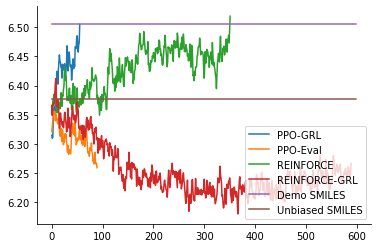

In [14]:
offset = 10
plt.plot(nbu.smoothing_values(ppo_grl_biased, 0.6)[offset:150])
plt.plot(nbu.smoothing_values(ppo_baseline_reward_biased, 0.6)[offset:])
plt.plot(nbu.smoothing_values(reinforce_biased, 0.6)[offset:])
plt.plot(nbu.smoothing_values(reinforce_grl_biased, 0.6)[offset:])
plt.plot(demo_vals)
plt.plot(unbiased_vals)
plt.legend(['PPO-GRL','PPO-Eval','REINFORCE','REINFORCE-GRL', 'Demo SMILES', 'Unbiased SMILES'], loc='lower right')
plt.savefig('jak2_max/jak2_max_irl_vs_rl_convergence.pdf')
sns.despine()

## t-SNE plot

In [15]:
hparams = {'d_model': 1500,
            'dropout': 0.0,
            'monte_carlo_N': 5,
            'use_monte_carlo_sim': True,
            'no_mc_fill_val': 0.0,
            'gamma': 0.97,
            'episodes_to_train': 10,
            'gae_lambda': 0.95,
            'ppo_eps': 0.2,
            'ppo_batch': 1,
            'ppo_epochs': 5,
            'entropy_beta': 0.01,
            'bias_mode': 'max',
            'use_true_reward': False,
            'baseline_reward': False,
            'reward_params': {'num_layers': 2,
                              'd_model': 512,
                              'unit_type': 'gru',
                              'demo_batch_size': 32,
                              'irl_alg_num_iter': 5,
                              'dropout': 0.2,
                              'use_attention': False,
                              'use_validity_flag': True,
                              'bidirectional': True,
                              'optimizer': 'adadelta',
                              'optimizer__global__weight_decay': 0.0005,
                              'optimizer__global__lr': 0.001, },
            'agent_params': {'unit_type': 'gru',
                             'num_layers': 2,
                             'stack_width': 1500,
                             'stack_depth': 200,
                             'optimizer': 'adadelta',
                             'optimizer__global__weight_decay': 0.005,
                             'optimizer__global__lr': 0.001},
            'critic_params': {'num_layers': 2,
                              'd_model': 256,
                              'dropout': 0.2,
                              'unit_type': 'gru',
                              'optimizer': 'adam',
                              'optimizer__global__weight_decay': 0.005,
                              'optimizer__global__lr': 0.001},
            'expert_model_dir': './model_dir/expert_xgb_reg'
            }

In [16]:
init_dict = nbu.initialize(hparams, generators['demo_data'], generators['unbiased_data'], True)

In [17]:
encoder = init_dict['encoder']
ppo_reward_net_rnn = init_dict['reward_net_rnn']
ppo_reward_net = init_dict['reward_net']
ppo_reward_net.load_state_dict(nbu.load_model_weights('../model_dir/JAK2_max_irelease_stack-rnn_gru_ppo_reward_net_2020_07_12__20_54_23_1.003_66.mod'))

<All keys matched successfully>

In [22]:
with torch.set_grad_enabled(False):
    reward_lst, logits_lst = [], []
    tsne_smiles = ppo_grl_smiles_valid + ppo_grl_smiles_invalid
    batch = 128
    for i in range(0, len(tsne_smiles), batch):
        inp, valid_vec = nbu.smiles_to_tensor(['<'+s+'>' for s in tsne_smiles[i:i+batch]])
        enc_out = encoder([inp, valid_vec])
        reward, logits = ppo_reward_net_rnn(enc_out, return_logits=True)
        reward_lst.append(reward)
        logits_lst.append(logits)
    reward = torch.cat(reward_lst)
    logits = torch.cat(logits_lst)

In [23]:
logits.shape, reward.shape

(torch.Size([9984, 1024]), torch.Size([9984, 1]))

In [24]:
tsne_rep = TSNE(n_components=2).fit_transform(logits.detach().cpu().numpy())
tsne_data = pd.DataFrame({'x':tsne_rep[:,0], 'y':tsne_rep[:,1]})
tsne_rep.shape

(9984, 2)

selected valid:
 ['CC(C)CC(NC(=O)C(CCCNC(=N)N)NCCO)C(N)C=O', 'CC(C)OC(=O)NCCC(C)(C)C(C)C', 'CCNc1nc(NC(C)C)nc(NC(C)C(=O)O)n1']
selected invalid:
 ['OCc1cc(F)c(F)c(l)c1-c1n1[nH]c2nc(ccc12)-c1ccncc1', 'Cn1nnc(-N2C(CCC2C1)C(F)(F)F)', 'OC(=O)c1csc2c(CCC(=O)N2C)c1CCN(CC(C)C)CCC']


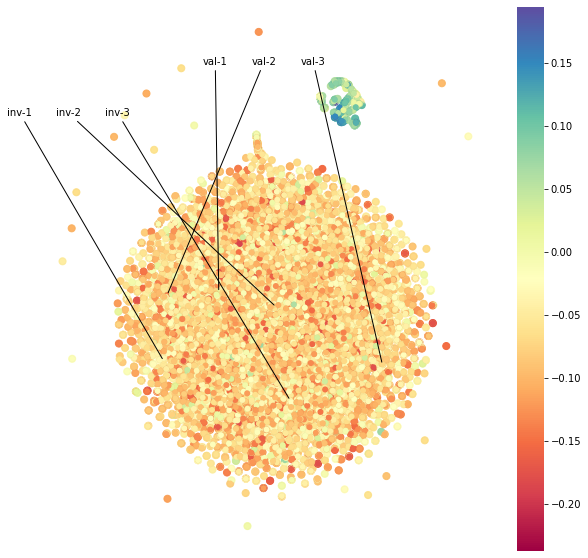

In [25]:
plt.figure(figsize=(10,10))
points = plt.scatter(tsne_data['x'], tsne_data['y'], c=reward.detach().cpu().numpy().reshape(-1,), s=50, cmap="Spectral")
cb = plt.colorbar(points, ticks=None)
cb.outline.set_visible(False)
ax = sns.scatterplot(x="x", y="y", hue=reward.detach().cpu().numpy().reshape(-1,), data=tsne_data, 
                    legend=False, palette='Spectral', edgecolor='black', linewidth=.01)
v = []
# valid SMILES
while True:
    va_idx = np.random.randint(len(ppo_grl_smiles_valid))
    comp = ppo_grl_smiles_valid[va_idx]
    i = len(v)+1
    if len(comp) <= 50:
        v.append(comp)
        ax.annotate('val-'+str(i), xy=(tsne_data['x'][va_idx], tsne_data['y'][va_idx]), 
                    xytext=(-20+(i*10),50), 
                    arrowprops=dict(facecolor='black', arrowstyle='-'),
                   horizontalalignment='right', verticalalignment='top')
        if len(v) == 3:
            break

inv = []
# invalid SMILES
for i in range(3):
    inv_idx = np.random.randint(len(ppo_grl_smiles_invalid))
    inv.append(ppo_grl_smiles_invalid[inv_idx])
    ax.annotate('inv-'+str(i+1), xy=(tsne_data['x'][len(ppo_grl_smiles_valid) + inv_idx], 
                    tsne_data['y'][len(ppo_grl_smiles_valid) + inv_idx]), 
                xytext=(-50+(i*10),40), arrowprops=dict(facecolor='black', arrowstyle='-'),
               horizontalalignment='right', verticalalignment='top')

print('selected valid:\n', v)
print('selected invalid:\n', inv)
plt.axis('off')
plt.savefig('jak2_max/jak2_max_ppo_grl_tsne.pdf')
plt.show()

##  Draw random SMILES

In [26]:
vis_mols = [Chem.MolFromSmiles(sm, sanitize=True) for sm in set(ppo_grl_smiles_valid) if len(sm)]# <= 50]
sanitized_gen_mols = [vis_mols[i] for i in np.where(np.array(vis_mols) != None)[0]]
len(sanitized_gen_mols)

5911

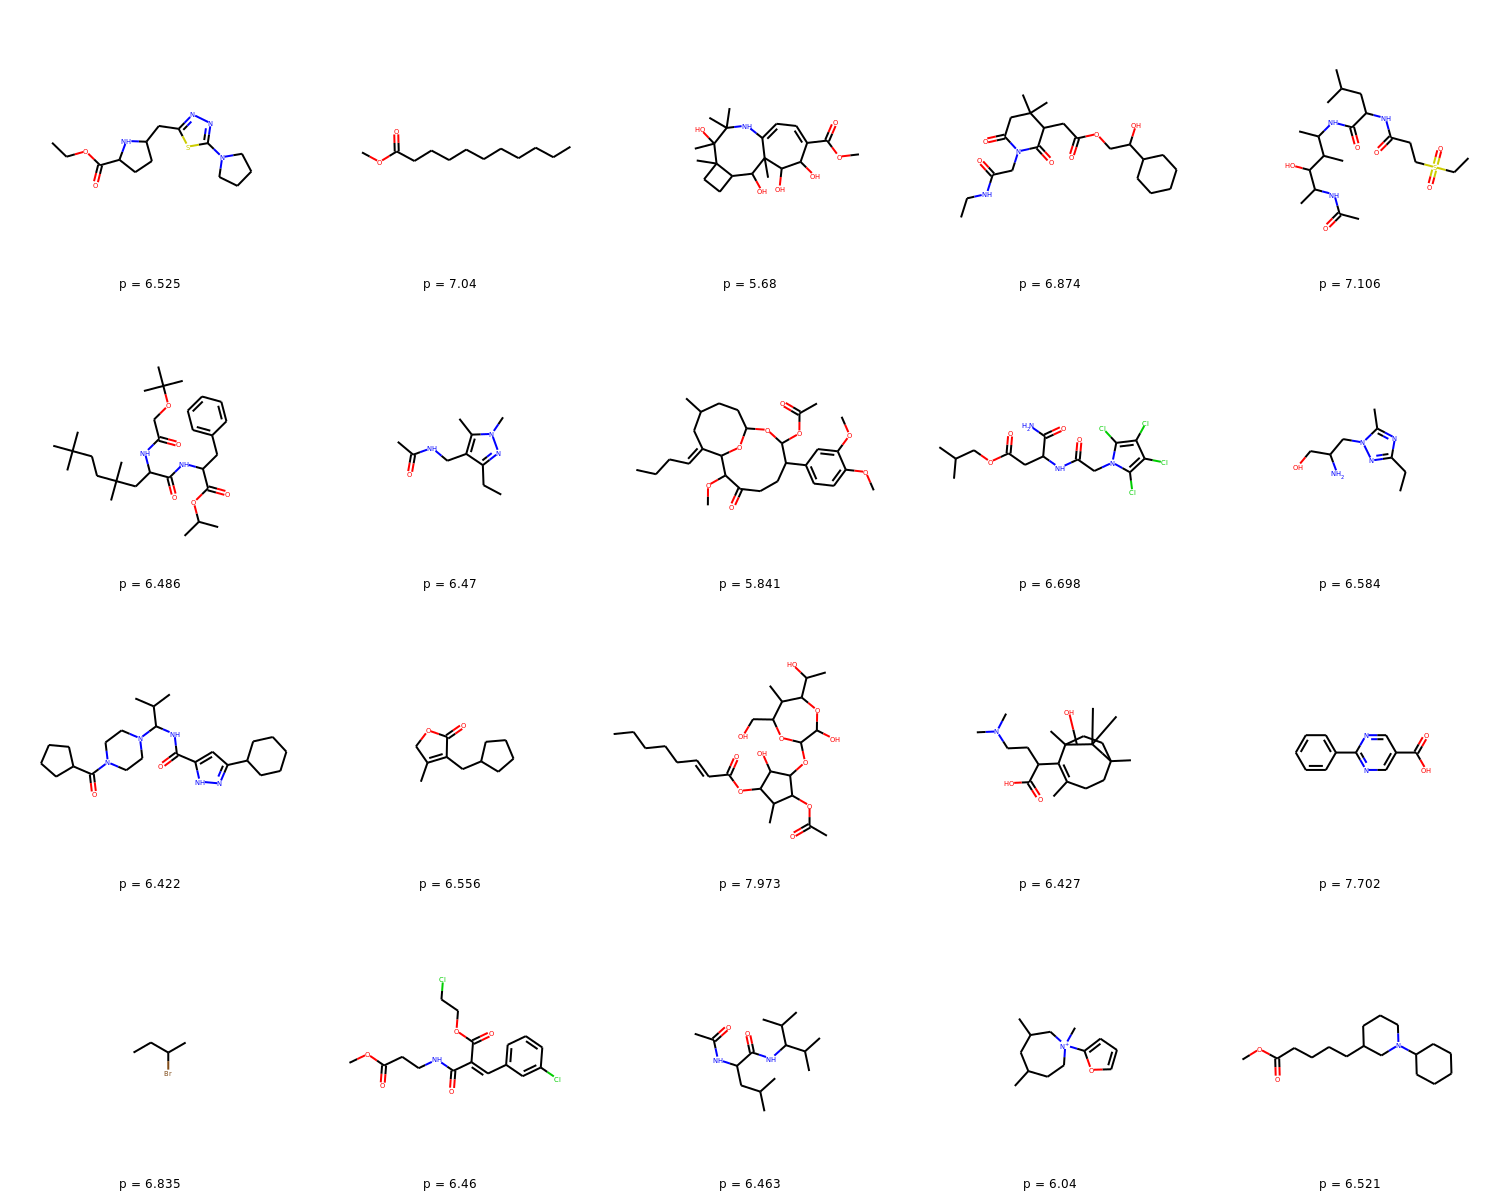

In [68]:
n_to_draw = 20
ind = np.random.randint(0, len(sanitized_gen_mols), n_to_draw)
mols_to_draw = [sanitized_gen_mols[i] for i in ind]
legends = ['p = ' + str(round(float(preds_ppo_grl_smiles[i]), 3)) for i in ind]
Draw.MolsToGridImage(mols_to_draw, molsPerRow=5, subImgSize=(300,300), legends=legends)

In [69]:
for i, mol in enumerate(mols_to_draw):
    print(f'{Chem.MolToSmiles(mol)}\t\t{legends[i]}')

CCOC(=O)C1CCC(Cc2nnc(N3CCCC3)s2)N1		p = 6.525
CCCCCCCCCCC(=O)OC		p = 7.04
COC(=O)C1=CC=C2NC(C)(C)C(C)(O)C3(C)CCC3C(O)C2(C)C(O)C1O		p = 5.68
CCNC(=O)CN1C(=O)CC(C)(C)C(CC(=O)OCC(O)C2CCCCC2)C1=O		p = 6.874
CCS(=O)(=O)CCC(=O)NC(CC(C)C)C(=O)NC(C)C(C)C(O)C(C)NC(C)=O		p = 7.106
CC(C)OC(=O)C(Cc1ccccc1)NC(=O)C(CC(C)(C)CCC(C)(C)C)NC(=O)COC(C)(C)C		p = 6.486
CCc1nn(C)c(C)c1CNC(C)=O		p = 6.47
CCCC=C1CC(C)CCC2OC(OC(C)=O)C(c3ccc(OC)c(OC)c3)CCC(=O)C(OC)C1O2		p = 5.841
CC(C)COC(=O)CC(NC(=O)Cn1c(Cl)c(Cl)c(Cl)c1Cl)C(N)=O		p = 6.698
CCc1nc(C)n(CC(N)CO)n1		p = 6.584
CC(C)C(NC(=O)c1cc(C2CCCCC2)n[nH]1)N1CCN(C(=O)C2CCCC2)CC1		p = 6.422
CC1=C(CC2CCCC2)C(=O)OC1		p = 6.556
CCCCCC=CC(=O)OC1C(C)C(OC(C)=O)C(OC2OC(CO)C(C)C(C(C)O)OC2O)C1O		p = 7.973
CC1=C(C(CCN(C)C)C(=O)O)C2(C)CCC(C)(CC1)CC(C)(C)C2O		p = 6.427
O=C(O)c1cnc(-c2ccccc2)nc1		p = 7.702
CCC(C)Br		p = 6.835
COC(=O)CCNC(=O)C(=Cc1cccc(Cl)c1)C(=O)OCCCl		p = 6.46
CC(=O)NC(CC(C)C)C(=O)NC(C(C)C)C(C)C		p = 6.463
CC1CC[N+](C)(c2ccco2)CC(C)C1		p = 6.04
COC(=O)CCCCC1

In [28]:
# Save selected compounds to file
# os.makedirs('./drd2_samples', exist_ok=True)
# for i, mol in enumerate(mols_to_draw):
#     Draw.MolToImageFile(mol, f'./drd2/sample_compound_{i+1}.png')

## Molecule metrics

In [73]:
def mol_metrics(df):
    results = {}
    num_can = 0
    for idx, df_smiles in enumerate([df, df[df['prediction'] >= np.mean(demo_vals)]]):
        new_smiles, valid_vec = canonical_smiles(df_smiles['SMILES'].tolist())
        smiles = []
        for i, s in enumerate(new_smiles):
            if valid_vec[i] == 1:
                smiles.append(s)
        eval_dict = nbu.evaluate(smiles, demo_smiles)
        eval_dict['Num of canonical SMILES'] = len(smiles)
        if idx==0:
            num_can = len(smiles)
        eval_dict['percentage of valid'] = df_smiles.shape[0] / 10000. * 100.
        if idx==1:            
            eval_dict['percentage in threshold (canonical)'] = len(smiles) / num_can
        results['no_threshold' if idx==0 else 'with_threshold'] = eval_dict
    return results

In [74]:
mol_metrics(preds_ppo_grl_eval)

{'no_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.6143007767760873,
  'internal_diversity': 0.9282383581706759,
  'conciseness': 1.0,
  'solubility': 0.5867584584309109,
  'naturalness': 0.6638868242815626,
  'synthesizability': 0.46794785139175094,
  'druglikeliness': 0.5806874974166699,
  'Num of canonical SMILES': 5911,
  'percentage of valid': 59.21999999999999},
 'with_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.5425195294212152,
  'internal_diversity': 0.9246692084429076,
  'conciseness': 1.0,
  'solubility': 0.578434187914398,
  'naturalness': 0.6997524267965779,
  'synthesizability': 0.3759222757722638,
  'druglikeliness': 0.5325428116276686,
  'Num of canonical SMILES': 2768,
  'percentage of valid': 27.76,
  'percentage in threshold (canonical)': 0.468279478937574}}

In [75]:
mol_metrics(preds_ppo_baseline_reward_eval)

{'no_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.3859082146768098,
  'internal_diversity': 0.9174276189887793,
  'conciseness': 1.0,
  'solubility': 0.6573731416251379,
  'naturalness': 0.5541679000782829,
  'synthesizability': 0.6438921142144859,
  'druglikeliness': 0.6044093563024587,
  'Num of canonical SMILES': 6937,
  'percentage of valid': 69.45},
 'with_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.36922705015568374,
  'internal_diversity': 0.9164862209166749,
  'conciseness': 1.0,
  'solubility': 0.6403190797986957,
  'naturalness': 0.5641926460439066,
  'synthesizability': 0.56514701476311,
  'druglikeliness': 0.5757877486378473,
  'Num of canonical SMILES': 2427,
  'percentage of valid': 24.33,
  'percentage in threshold (canonical)': 0.3498630531930229}}

In [76]:
mol_metrics(preds_reinforce_eval)

{'no_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.35091880024459476,
  'internal_diversity': 0.9156004867547303,
  'conciseness': 1.0,
  'solubility': 0.6083063601491883,
  'naturalness': 0.6080352452868083,
  'synthesizability': 0.5286519833816157,
  'druglikeliness': 0.6265358440985416,
  'Num of canonical SMILES': 6768,
  'percentage of valid': 67.82000000000001},
 'with_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.2806982120858218,
  'internal_diversity': 0.9120040573048571,
  'conciseness': 1.0,
  'solubility': 0.5860284383227051,
  'naturalness': 0.6089797656130561,
  'synthesizability': 0.46234789745705723,
  'druglikeliness': 0.6051846554673815,
  'Num of canonical SMILES': 2942,
  'percentage of valid': 29.509999999999998,
  'percentage in threshold (canonical)': 0.43469267139479906}}

In [77]:
mol_metrics(preds_reinforce_grl_eval)

{'no_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.3813502115627386,
  'internal_diversity': 0.9172103770881908,
  'conciseness': 1.0,
  'solubility': 0.6582503382365282,
  'naturalness': 0.5552509018032847,
  'synthesizability': 0.6442857132745173,
  'druglikeliness': 0.6067871530877008,
  'Num of canonical SMILES': 7039,
  'percentage of valid': 70.46},
 'with_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.3546940824985614,
  'internal_diversity': 0.9158188572111808,
  'conciseness': 1.0,
  'solubility': 0.6441116167041047,
  'naturalness': 0.5614737942960732,
  'synthesizability': 0.5679028956729744,
  'druglikeliness': 0.5771666350348618,
  'Num of canonical SMILES': 2508,
  'percentage of valid': 25.11,
  'percentage in threshold (canonical)': 0.3563006108822276}}

In [78]:
mol_metrics(preds_demo)

{'no_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.011272744387773514,
  'internal_diversity': 0.6459985919044191,
  'conciseness': 1.0,
  'solubility': 0.9464952490760901,
  'naturalness': 0.683378652408242,
  'synthesizability': 0.5566955619650434,
  'druglikeliness': 0.10866520954630857,
  'Num of canonical SMILES': 10000,
  'percentage of valid': 100.0},
 'with_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.0013145073147109605,
  'internal_diversity': 0.5432864083192965,
  'conciseness': 1.0,
  'solubility': 0.954304099522299,
  'naturalness': 0.6745286084698028,
  'synthesizability': 0.5102764338632516,
  'druglikeliness': 0.08726231548488989,
  'Num of canonical SMILES': 5657,
  'percentage of valid': 56.57,
  'percentage in threshold (canonical)': 0.5657}}

In [79]:
mol_metrics(preds_unbiased)

{'no_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.3792674219122904,
  'internal_diversity': 0.9172093645408316,
  'conciseness': 1.0,
  'solubility': 0.6537168149513535,
  'naturalness': 0.554249677373528,
  'synthesizability': 0.6410245249259279,
  'druglikeliness': 0.6037894919031428,
  'Num of canonical SMILES': 10000,
  'percentage of valid': 100.0},
 'with_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.3598633249269879,
  'internal_diversity': 0.9160876773080566,
  'conciseness': 1.0,
  'solubility': 0.6392547344630046,
  'naturalness': 0.5723041129480143,
  'synthesizability': 0.565014702906119,
  'druglikeliness': 0.5720246824427468,
  'Num of canonical SMILES': 3537,
  'percentage of valid': 35.370000000000005,
  'percentage in threshold (canonical)': 0.3537}}

## RNN hidden neurons examination

In [169]:
# def plot_heatmap(smiles_list, logits, neuron=None, save=False):
#     if neuron is None:
#         neuron = np.random.randint(logits.shape[-1])
#     print(f'Plotting for neuron {neuron}')
#     for i, smiles in enumerate(smiles_list):
#         arr = logits[:len(smiles), i, neuron].reshape(1, len(smiles))
#         chars = np.array([c for c in smiles]).reshape(1,-1)
#         fig = plt.figure(figsize=(200,4))
#         sns.heatmap(arr, annot=chars, fmt='', cbar=False, 
#                     cmap=sns.color_palette("bwr", 10), annot_kws={'size':100, 'fontweight':'normal'},
#                    xticklabels=False, yticklabels=False, square=True)
#         if save:
#             os.makedirs(f'drd2/neuron_{neuron}', exist_ok=True)
#             plt.savefig(f'drd2/neuron_{neuron}/{i}.png')
#         plt.show()

In [ ]:
# plot_heatmap(ppo_samples[:10], ppo_samples_neurons[:,:10,:])